In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, optimize
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.integrate import odeint
from lmfit import minimize, Parameters, fit_report
from matplotlib import ticker

%matplotlib inline

Data collation and analysis. Data is available as both an excel spreadsheet and csv file in this repo. 

In [2]:
os.chdir('C:\\Users\\euler\\Documents\\Project\\Flux-Sensing')

In [3]:
gerosa = pd.read_excel('FS_data.xlsx',sheet_name='Gerosa',index_col = 'metab')
kochanowski = pd.read_excel('FS_data.xlsx',sheet_name='Kochanowski',index_col = 'metab')
bennett = pd.read_excel('FS_data.xlsx',sheet_name='Bennett', index_col = 'metab')
fluxes = pd.read_excel('FS_data.xlsx',sheet_name = 'Fluxes',index_col = 'flux')

In [4]:
metabs = set(gerosa.index).union(set(kochanowski.index))

In [5]:
data = pd.DataFrame(index = metabs)
data.drop('Citrate/Isocitrate',inplace=True) 
#Citrate and isocitrate concentrations are not distinguished in the Kochanowski set.
#We calculated these concentrations from the reported pooled concentration using the Keq value for this reaction.
for key in kochanowski.keys():
    data[key] = 0

In [6]:
#Collation. Some metabolites are only in one or two of the data sets. This block accounts for that in calculating means and
#standard deviations of pooled data. All concentrations are in millimolar and all fluxes are in millimolar/h

for carbon_source in kochanowski.keys():
    if carbon_source.split('_')[1] == 'mean':
        if carbon_source in gerosa.keys():
            if carbon_source in bennett.keys():

                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = (3*gerosa[carbon_source].loc[metab] + 3*bennett[carbon_source][metab] + 4*kochanowski[carbon_source][metab])/10
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = (gerosa[carbon_source].loc[metab] + bennett[carbon_source][metab])/2
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
            else:
        
                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = (3*gerosa[carbon_source].loc[metab] + 4*kochanowski[carbon_source][metab])/7
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = gerosa[carbon_source].loc[metab]
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
        
        if carbon_source not in gerosa.keys():
            data[carbon_source] = kochanowski[carbon_source]
            
    if carbon_source.split('_')[1] == 'std':
        if carbon_source in gerosa.keys():
            if carbon_source in bennett.keys():

                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = np.sqrt((gerosa[carbon_source].loc[metab]**2 + bennett[carbon_source][metab]**2 + kochanowski[carbon_source][metab]**2)/3)
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = np.sqrt((gerosa[carbon_source].loc[metab]**2 + bennett[carbon_source][metab]**2)/2)
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
            else:
        
                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = np.sqrt((2*gerosa[carbon_source].loc[metab]**2 + 3*kochanowski[carbon_source][metab]**2)/3)
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = gerosa[carbon_source].loc[metab]
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
        
        if carbon_source not in gerosa.keys():
            data[carbon_source] = kochanowski[carbon_source]

C:\Users\euler\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
means = data.loc[:,[x for x in data.keys() if x.split('_')[1] == 'mean']]
means.drop('Glutamate',inplace=True) 
#Glutamate concentration is significantly higher than all other concentrations in all conditions and data sets.
#We excluded it here to avoid issues with data visualization for this reason.

mean_fluxes = fluxes.loc[:,[x for x in fluxes.keys() if x.split('_')[1] == 'mean']]
mean_fluxes.drop(index='ME',inplace=True)

In [11]:
flux_corr = pd.DataFrame(index = mean_fluxes.index, columns = means.index)
corr_strength = pd.DataFrame(index = mean_fluxes.index, columns = means.index)

In [12]:
for i in mean_fluxes.index:
    for j in means.index:
        if means.loc[j,mean_fluxes.keys()].isnull().values.any():
            continue
        else:
            flux_corr.loc[i,j] = scipy.stats.pearsonr(mean_fluxes.loc[i,:], means.loc[j,mean_fluxes.keys()])[0]
            corr_strength.loc[i,j] = scipy.stats.linregress(mean_fluxes.loc[i,:], means.loc[j,mean_fluxes.keys()])[0]

In [15]:
flux_corr.drop(index = [x for x in flux_corr.index if 'Export' in x], columns = 'Gal1P',inplace=True)
flux_corr = flux_corr.astype('double')
corr_strength.drop(index = [x for x in corr_strength.index if 'Export' in x], columns = 'Gal1P',inplace=True)
corr_strength = corr_strength.astype('double')

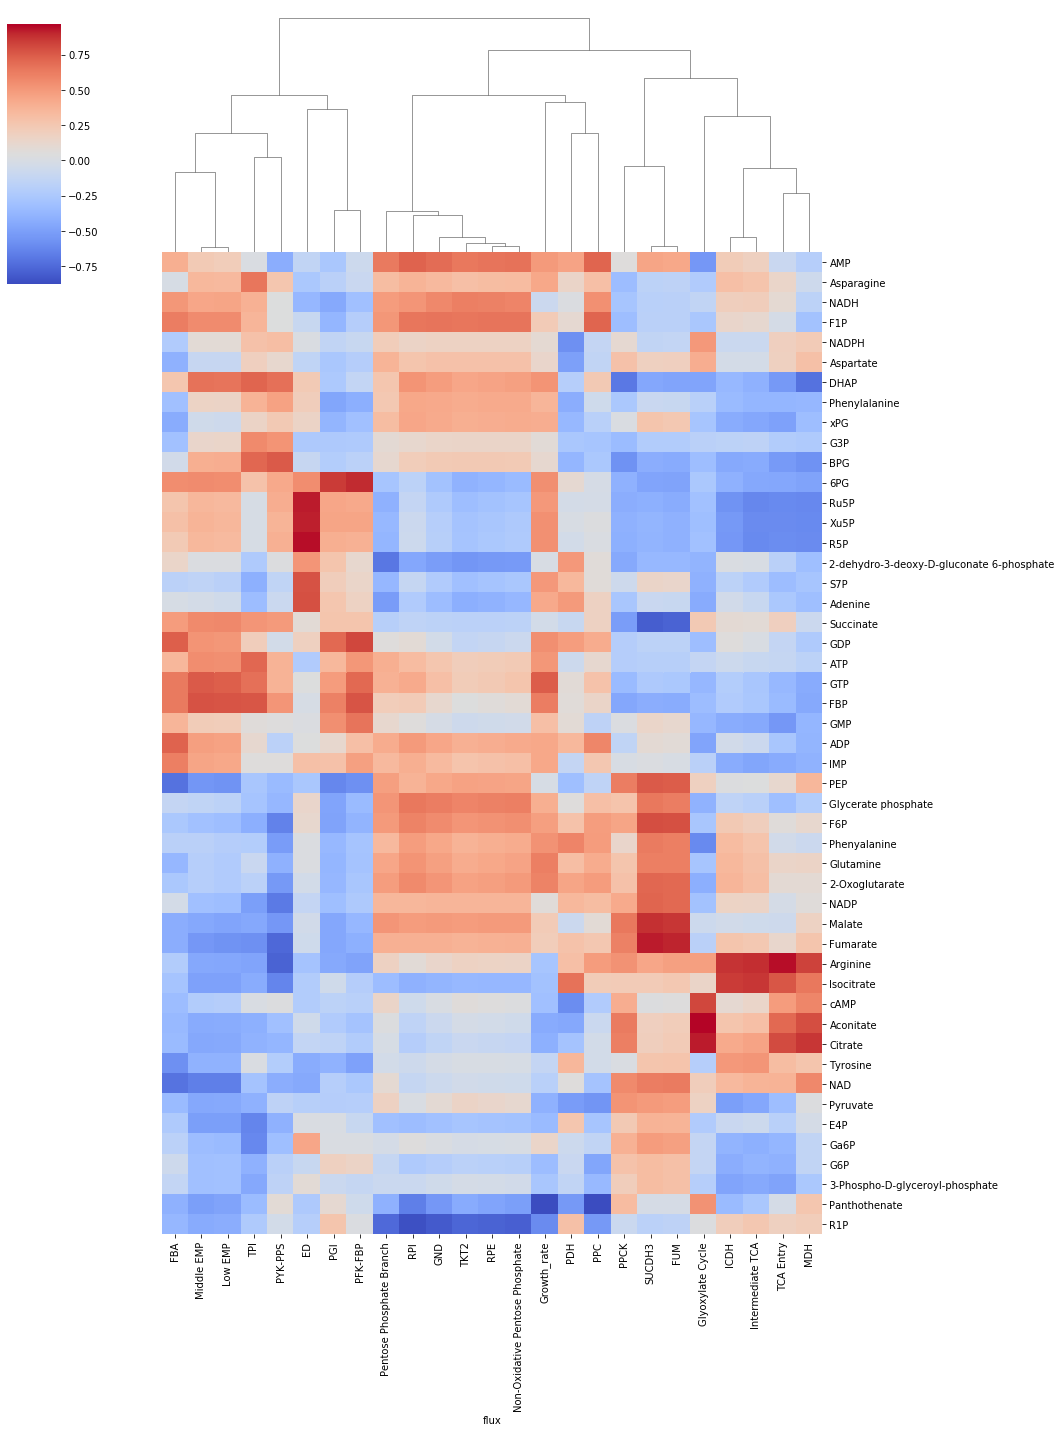

In [16]:
cm = sns.clustermap(flux_corr.T, cmap = 'coolwarm',figsize=(15,20))
cm.ax_row_dendrogram.set_visible(False)

With the data collated and clean, we moved to analysis for the bottlenecks revealed by the correlation structure. 

First, we analyzed the citrate-TCA cycle flux relationship:

In [17]:
#Residual function for fit to model

def residual(params, x, data, eps_data):
    V_m = params['V_m']
    alpha = params['alpha']

    model = x/(V_m-x)*alpha

    return (data-model)

In [75]:
params = Parameters()
params.add('V_m', value=4.59, min=0) #Initial values based on qualitative analysis of the concentration-flux curve 
params.add('alpha', value=1.17,min=0)

In [76]:
x = mean_fluxes.loc['TCA Entry']
y = means.loc['Citrate',mean_fluxes.keys()]
xerr = fluxes.loc['TCA Entry',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Citrate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

out = minimize(residual, params, args=(x.values, y.values, yerr.values))

In [77]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 8
    # variables        = 2
    chi-square         = 1.93396684
    reduced chi-square = 0.32232781
    Akaike info crit   = -7.35894631
    Bayesian info crit = -7.20006323
[[Variables]]
    V_m:    4.03955556 +/- 0.06951905 (1.72%) (init = 4.59)
    alpha:  0.39825815 +/- 0.13257173 (33.29%) (init = 1.17)
[[Correlations]] (unreported correlations are < 0.100)
    C(V_m, alpha) =  0.978


In [78]:
1 - out.redchi / np.var(y, ddof=2) #Correlation coefficient calculation

0.955496116524639

In [79]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
V_m,4.03955556,0.06951905,(1.72%),4.59,0.00000000,inf,True
alpha,0.39825815,0.13257173,(33.29%),1.17,0.00000000,inf,True


In [80]:
#Model declaration for plotting
def model(x,V_m,alpha):
    return x/(V_m-x)*alpha

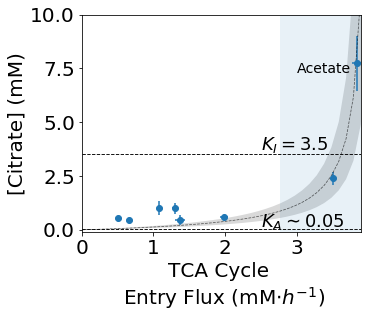

In [82]:
fig,ax = plt.subplots(figsize=(5,4))

x_model = np.linspace(0,4,40)
x = mean_fluxes.loc['TCA Entry']
y = means.loc['Citrate',mean_fluxes.keys()]
xerr = fluxes.loc['TCA Entry',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Citrate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

V = out.params['V_m'].value
V_upper = out.params['V_m'].value + out.params['V_m'].stderr
V_lower = out.params['V_m'].value - out.params['V_m'].stderr

a = out.params['alpha'].value
a_upper = out.params['alpha'].value + out.params['alpha'].stderr
a_lower = out.params['alpha'].value - out.params['alpha'].stderr

ax.axhline(0.05,linestyle='--',color='k',linewidth=0.9)
ax.axhline(3.5,linestyle='--',color='k',linewidth=0.9)
ax.fill_between(x_model,model(x_model,V_lower,a_upper),model(x_model,V_upper,a_lower),alpha=0.15,color='k',linewidth=0)
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax.plot(x_model,model(x_model,V,a),linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
ax.axvspan(V-(V*a)**0.5,3.9,alpha=0.1)

ax.set_xlabel('TCA Cycle \n Entry Flux (mM$\cdot h^{-1}$)',fontsize=20)
ax.set_ylabel('[Citrate] (mM)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.text(3,7.3,'Acetate',fontsize=14)
ax.text(2.5,3.72,r'$K_I = 3.5$', fontsize=18)
ax.text(2.5,0.15,r'$K_A \sim 0.05$',fontsize=18)

plt.xlim(0,3.9)
plt.ylim(-0.1,10)

#plt.savefig('TCA-citrate.pdf',bbox_inches='tight')
#plt.savefig('TCA-citrate.png',bbox_inches='tight')

Next we analyzed the malate-fumarase relationship in the same way

In [83]:
params = Parameters()
params.add('V_m', value=12, min=0)
params.add('alpha', value=4.5,min=0)

In [84]:
x_model = np.linspace(0,8,80)
x = mean_fluxes.loc['FUM']
y = means.loc['Malate',mean_fluxes.keys()]
xerr = fluxes.loc['FUM',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Malate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

out = minimize(residual, params, args=(x.values, y.values, yerr.values))

In [85]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 8
    # variables        = 2
    chi-square         = 9.58663012
    reduced chi-square = 1.59777169
    Akaike info crit   = 5.44742313
    Bayesian info crit = 5.60630621
[[Variables]]
    V_m:    11.8988063 +/- 3.16972321 (26.64%) (init = 12)
    alpha:  6.19484876 +/- 4.25971551 (68.76%) (init = 4.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(V_m, alpha) =  0.986


In [86]:
1 - out.redchi / np.var(y, ddof=2)

0.8652862738947247

In [87]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
V_m,11.8988063,3.16972321,(26.64%),12,0.00000000,inf,True
alpha,6.19484876,4.25971551,(68.76%),4.5,0.00000000,inf,True


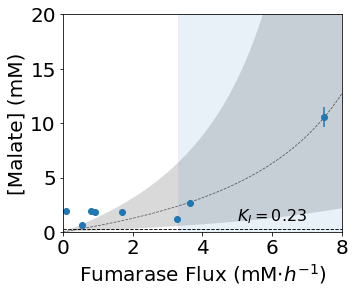

In [88]:
fig,ax = plt.subplots(figsize=(5,4))

V = out.params['V_m'].value
V_upper = out.params['V_m'].value + out.params['V_m'].stderr
V_lower = out.params['V_m'].value - out.params['V_m'].stderr

a = out.params['alpha'].value
a_upper = out.params['alpha'].value + out.params['alpha'].stderr
a_lower = out.params['alpha'].value - out.params['alpha'].stderr

ax.axhline(0.23,linestyle='--',color='k',linewidth=0.9)
ax.fill_between(x_model,model(x_model,V_upper,a_lower),model(x_model,V_lower,a_upper),alpha=0.15,color='k',linewidth=0)
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax.plot(x_model,model(x_model,V,a),linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
ax.axvspan(V-(V*a)**0.5,8,alpha=0.1)

ax.set_xlabel(r'Fumarase Flux (mM$\cdot h^{-1}$)',fontsize=20)
ax.set_ylabel('[Malate] (mM)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.text(5,1,r'$K_I = 0.23$',fontsize=16)

plt.xlim(0,8)
plt.ylim(0,20)
#plt.savefig('FUM-malate.pdf',bbox_inches='tight')
#plt.savefig('FUM-malate.png',bbox_inches='tight')

For the pentose phosphate intermediates next, we used a simple linear regression because the data is sufficiently linear. This is consistent with our analysis that at low concentrations corresponding to relatively weak flux-concentration correlations, this relationship should be linear.

0.9267579930588852
0.9434209141140173
0.9145030431388861
0.7819353324049554


Text(-0.04, 0.25, 'Concentrations (mM)')

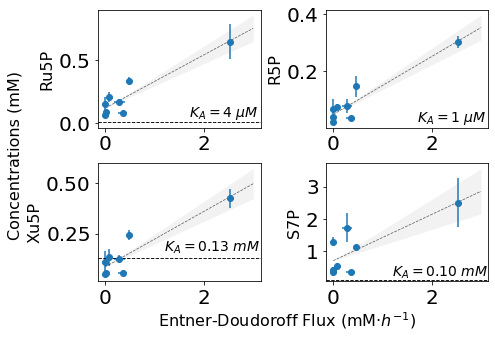

In [96]:
PPP = ['Ru5P','R5P','Xu5P','S7P']

fig,ax = plt.subplots(2,2,figsize=(7,5))
ax = ax.flatten()

x = mean_fluxes.loc['ED']
xerr = fluxes.loc['ED',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

for met in PPP:

    y = means.loc[met,mean_fluxes.keys()]
    yerr = data.loc[met,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
    ax[PPP.index(met)].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
    ax[PPP.index(met)].set_ylabel(met,fontsize=16)
    ax[PPP.index(met)].tick_params(axis='both', which='major', labelsize=20)
    
    slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
    x_model = np.linspace(0,3,100)
    ax[PPP.index(met)].plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
    ax[PPP.index(met)].fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,alpha=0.05,color='k',linewidth=0)
    print(r_value)
    
    if met == 'Ru5P':
        ax[PPP.index(met)].axhline(0.004,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.7,0.05,r'$K_A = 4 \; \mu M$',fontsize=14)
        
    elif met == 'R5P':
        ax[PPP.index(met)].axhline(0.001,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.7,0.02,r'$K_A = 1 \; \mu M$',fontsize=14)
    elif met == 'Xu5P':
        ax[PPP.index(met)].axhline(0.13,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.2,0.16,r'$K_A = 0.13 \; mM$',fontsize=14)
    elif met == 'S7P':
        ax[PPP.index(met)].axhline(0.1,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.2,0.2,r'$K_A = 0.10 \; mM$',fontsize=14)

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.0005, 'Entner-Doudoroff Flux (mM$\cdot h^{-1}$)', ha='center',fontsize=16)
fig.text(-0.04, 0.25, 'Concentrations (mM)', ha='center',fontsize=16, rotation=90)

#plt.savefig('PPP-ED.pdf',bbox_inches='tight')
#plt.savefig('PPP-ED.png',bbox_inches='tight')

We took a similar approach with PEP simply to demonstrate that any correlation between PEP concentration and phosphoenolpyruvate carboxykinase flux is not statistically significant.

(0, 1)

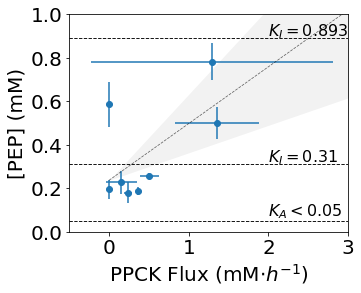

In [95]:
x = mean_fluxes.loc['PPCK']
y = means.loc['PEP',mean_fluxes.keys()]
xerr = fluxes.loc['PPCK',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['PEP',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
print(r_value)

fig,ax = plt.subplots(figsize=(5,4))

x_model = np.linspace(0,3,30)
x = mean_fluxes.loc['PPCK']
y = means.loc['PEP',mean_fluxes.keys()]
xerr = fluxes.loc['PPCK',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['PEP',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

ax.axhline(0.05,linestyle='--',color='k',linewidth=0.9)
ax.axhline(0.893,linestyle='--',color='k',linewidth=0.9)
ax.axhline(0.31,linestyle='--',color='k',linewidth=0.9)
ax.fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,alpha=0.05,color='k',linewidth=0)
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax.plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)

ax.set_xlabel(r'PPCK Flux (mM$\cdot h^{-1}$)',fontsize=20)
ax.set_ylabel('[PEP] (mM)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.text(2,0.075,r'$K_A < 0.05$',fontsize=16)

ax.text(2,0.9,r'$K_I = 0.893$',fontsize=16)
ax.text(2,0.32,r'$K_I = 0.31$', fontsize=16)

plt.xlim(-0.5,3)
plt.ylim(0,1)
plt.savefig('PPCK-PEP.pdf',bbox_inches='tight')
plt.savefig('PPCK-PEP.png',bbox_inches='tight')

For the remaining metabolites, no obvious flux-concentration relationship appeared. However, this may be due to insufficient variation in local fluxes across the data available, which does not include tarageted manipulation of fluxes. For these metabolites, we looked for outlying concentrations across the conditions as a form of weak evidence in support of flux-sensing relationships.

Text(0.5, 0.05, 'Metabolite Concentration')

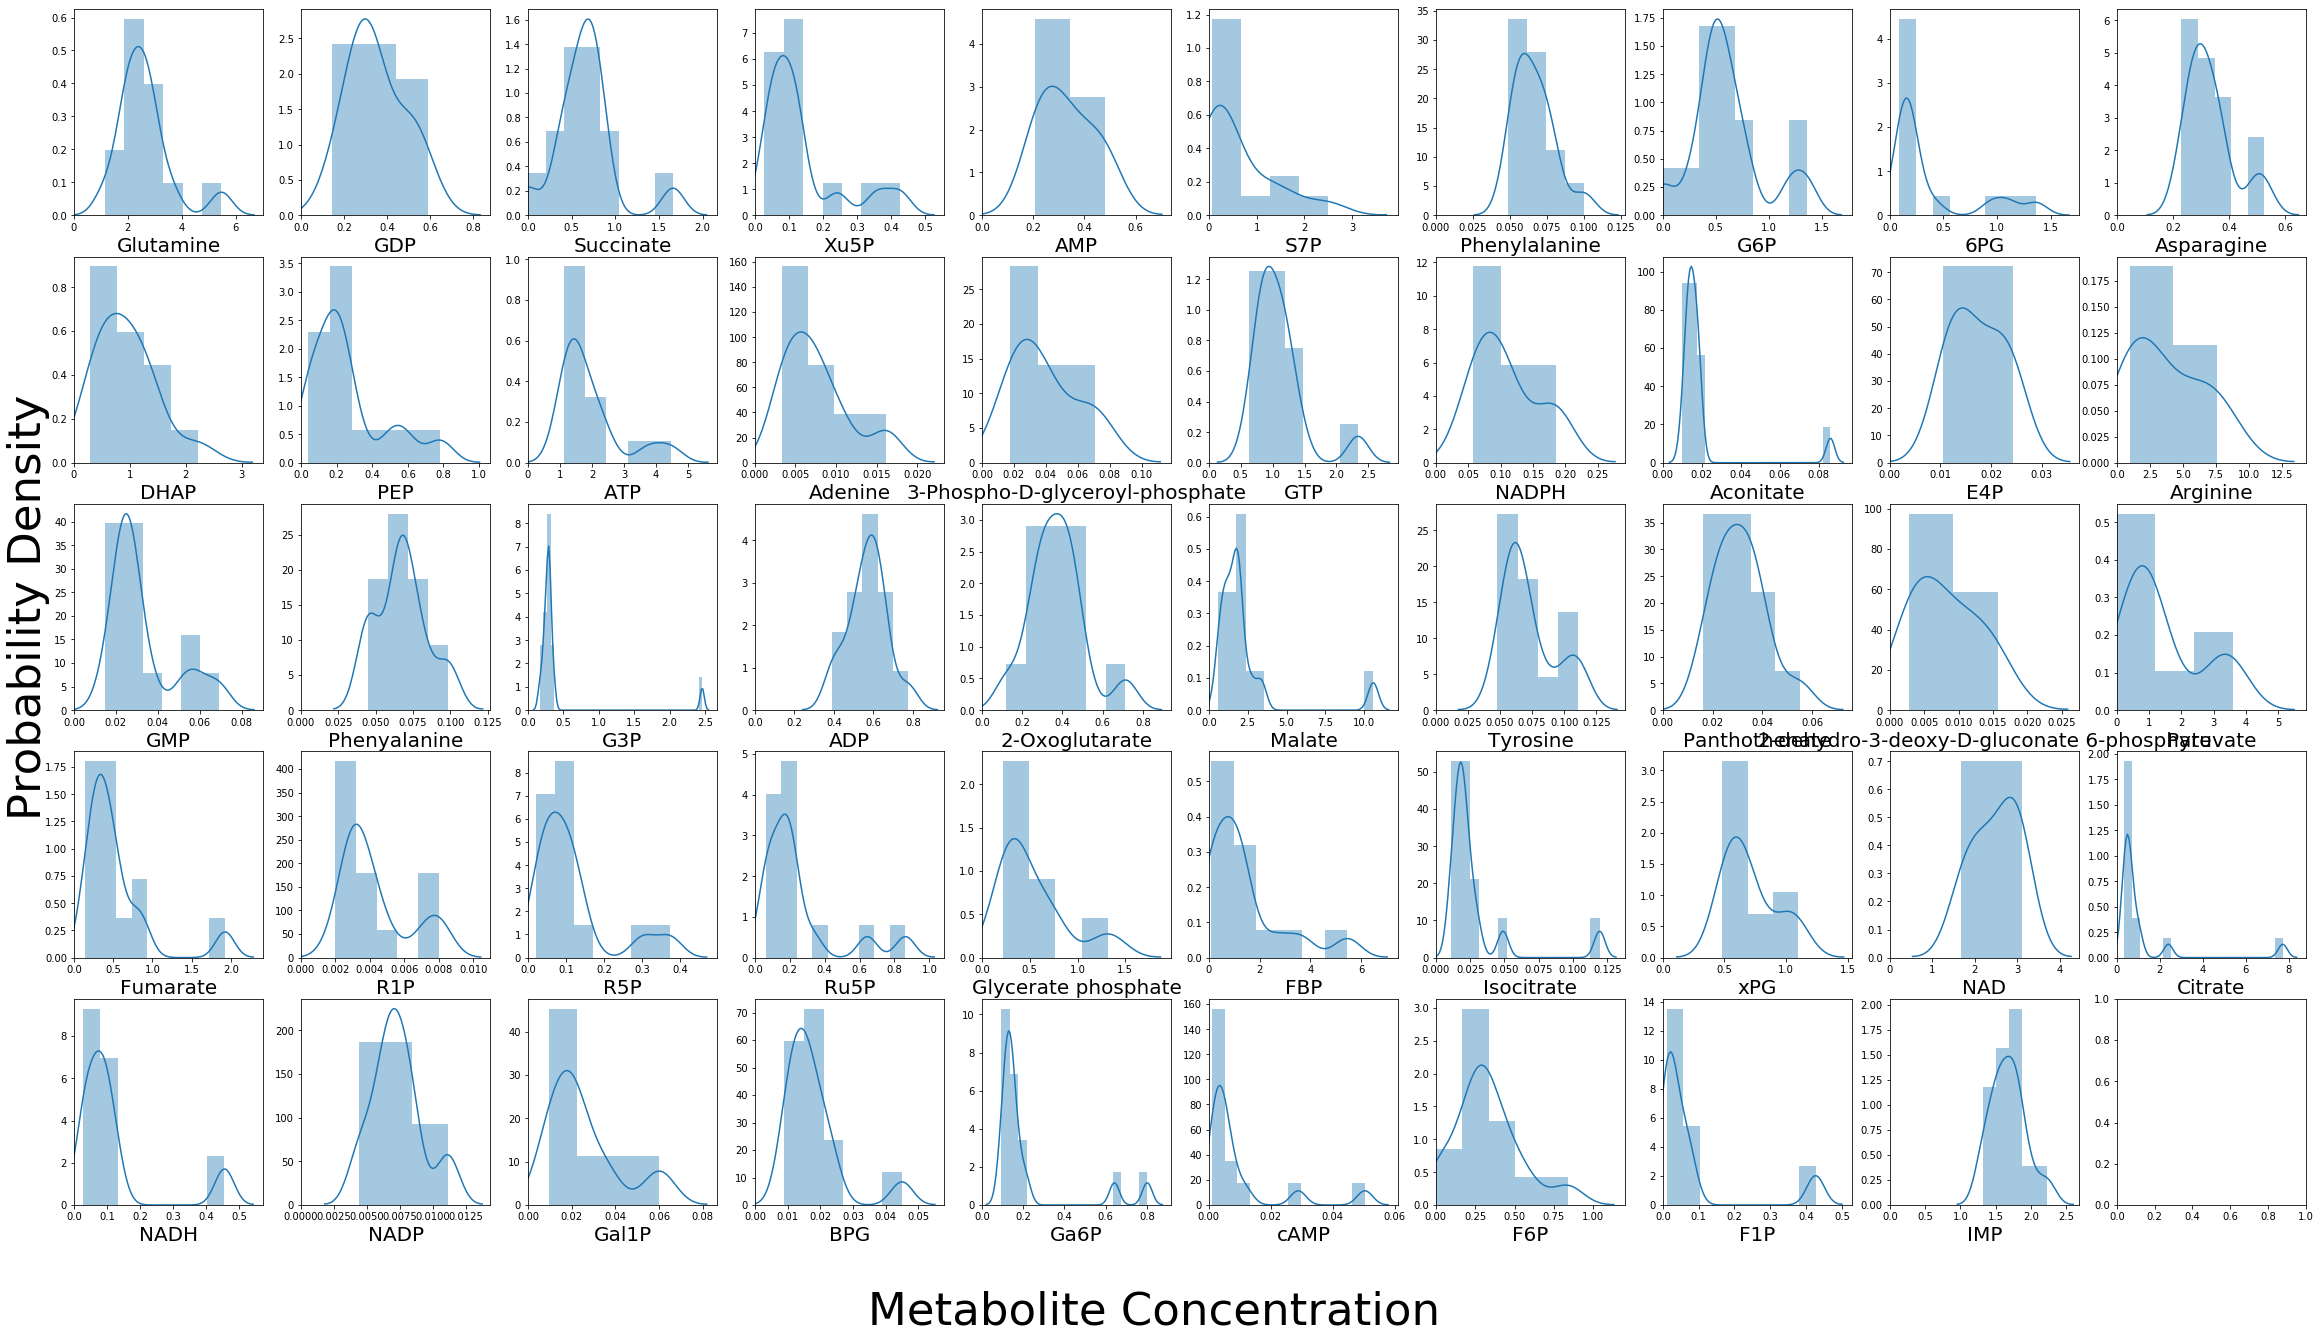

In [8]:
fig,ax = plt.subplots(5,10,figsize=(40,22))
ax = ax.flatten()

for i in range(0,len(means.index)-1):
    if i == 20:
        ax[i].set_ylabel('Probability Density',fontsize=45)
        
    b = sns.distplot(means.loc[means.index[i],:],ax=ax[i])
    b.set_xlabel(means.index[i],fontsize=20)
    ax[i].set_xlim(0,)
fig.text(0.5, 0.05, 'Metabolite Concentration', ha='center',fontsize=45)

#plt.savefig('distributions.pdf',bbox_inches='tight')
#plt.savefig('distributions.png',bbox_inches='tight')

In [9]:
#Definition of a function which carries out the Grubbs test for outliers. 
def Grubbs(x,alpha):
    y = [z for z in x if np.isnan(z)  == False and z > 0.]
    
    avg = np.mean(y)
    std = np.std(y)
    N = len(y)
    
    test_stat = max(y-avg)/std
    
    t_dist = stats.t.ppf(1-alpha/(2*N),N-2)
    G_crit = (N-1)/np.sqrt(N)*np.sqrt(t_dist**2/(N-2+t_dist**2))
    
    if test_stat > G_crit:
        result = 1
    else:
        result = 0
    
    return result

#Running the Grubbs test on all concentration distributions at a significance of p<0.01.
#If a metabolite concentration has an outlying concentration, this reflects potential for a flux-sensing relationship in the 
#metabolic context corresponding to that concentration.
#We expect this list to overlap significantly with that in 
#Wegner A, Meiser J, Weindl D, Hiller K. How metabolites modulate metabolic flux. 
#Current Opinion in Biotech599 nology. 2015; 34:16–22. 
#http://dx.doi.org/10.1016/j.copbio.2014.11.008, doi: 10.1016/j.copbio.2014.11.008

for metab in means.index:
    x = means.loc[metab,:]
    grubbs = Grubbs(x,0.01)
    if grubbs == 1:
        print([metab,x.idxmax()])
    else:
        continue

Text(1.9, 1.5, 'Glycerol')

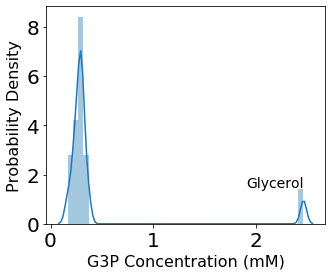

In [97]:
fig,ax = plt.subplots(figsize=(5,4))

ax = sns.distplot(means.loc['G3P',:],norm_hist=True,axlabel=False)
ax.set_ylabel('Probability Density',fontsize=16)
ax.set_xlabel('G3P Concentration (mM)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.text(1.9,1.5, 'Glycerol',fontsize=14)
#plt.savefig('G3P.pdf',bbox_inches='tight')
#plt.savefig('G3P.png',bbox_inches='tight')

In the next section, we develop and visualize the theory presented in the manuscript. First, we examined the relationship between concentrations and fluxes under different constraint scenarios. 

In [98]:
#Function corresponding to equation 2 in the manuscript
def irrev(x,V,K):
    return x/(V-x)*K

In [99]:
#Function corresponding to equation 3 in the manuscript
def irrev_sens(x,V,K):
    return x/(V-x)**2*K

In [100]:
#Function corresponding to equation 6/7 in the manuscript
def rev(x,V,Ks,Kp,k,Keq):
    return x/(V-x)*(Ks+Ks/(k*Kp)*x+V/(k*Keq))

In [101]:
#Function corresponding to 9/10 in the manuscript
def rev_sens(x,V,Ks,Kp,k,Keq):
    return (V*Ks+x*(2*V-x)*Ks/(k*Kp)+V**2/(k*Keq))/(V-x)**2

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


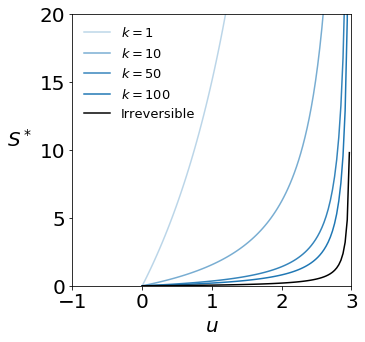

In [102]:
fig,ax = plt.subplots(figsize=(5,5))
x = np.linspace(0,3,100)
K_vals = [1,10,50,100]
K=0.1
V = 3
Kp = 1
Ks = 0.1
alpha = [0.3,0.6,0.9,1]

for k in K_vals:
    #alpha = K_vals.index(K)/len(K_vals)
    ax.plot(x,rev(x,V,Ks,Kp,k,K),color = 'C00000',alpha=alpha[K_vals.index(k)],label = r'$k =$'+str(k))
ax.set_ylim(0,20)
ax.set_xlim(-1,3)
ax.plot(x,irrev(x,V,Ks),color='k',label = 'Irreversible')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc='best',frameon=False,facecolor='w',framealpha=1,fontsize=13)
ax.set_xlabel(r'$u$',fontsize=20)
ax.set_ylabel(r'$S^*$',fontsize=20,rotation=0,labelpad=20)
ax.axvline(V,linestyle='--',color='k',linewidth=0.75)

#plt.savefig('turnover.pdf',bbox_inches='tight')
#plt.savefig('turnover.png',bbox_inches='tight')

In [111]:
#Dynamic system corresponding to the many consuming reactions case in Fig 2A and discussed in Appendix 1
def multi(x,t,k):
    
    dxdt = k - 1*x[0]/(0.1+x[0]) - 1.5*x[0]/(0.1+x[0]/0.1) - 2*x[0]/(0.1+x[0]) - 3*x[0]/(0.1+x[0]) - 5*x[0]/(0.1+x[0])
    dp1dt = 1*x[0]/(0.1+x[1]) - x[1]/(0.1+x[1])
    dp2dt = 1.5*x[0]/(0.1+x[0]) - x[2]/(0.1+x[2])
    dp3dt = 2*x[0]/(0.1+x[0]) - x[3]/(0.1+x[3])
    dp4dt = 3*x[0]/(0.1+x[0]) - x[4]/(0.1+x[4])
    dp5dt = 5*x[0]/(0.1+x[0]) - x[5]/(0.1+x[5]) 
    y = [dxdt, dp1dt, dp2dt, dp3dt, dp4dt, dp5dt]
    
    return y

In [112]:
#Function to extract rates at steady state for the above system
def rates(x,k):
    p1 = x[1]/(0.1+x[1])
    p2 = x[2]/(0.1+x[2])
    p3 = x[3]/(0.1+x[3])
    p4 = x[4]/(0.1+x[4])
    p5 = x[5]/(0.1+x[5])
    return [p1,p2,p3,p4,p5]

In [113]:
#Examining the effect that varying the influx has on the concentration of downstream metabolites in the many consuming reactions
#case. 

out_x = []
out_p1 = []
out_p2 = []
out_p3 = []
out_p4 = []
out_p5 = []
test = []

fluxes = np.linspace(0,15,100)
n = 200
t = np.linspace(0,200,n)
x0 = [0,0,0,0,0,0]
s=[]

for flux in fluxes:
    k = flux
    y = odeint(multi,x0,t,args = (k,))
    r = rates(y,k)
    s.append(y[0][0])
    out_x.append(y[-1][0])
    out_p1.append(y[-1][1])
    out_p2.append(y[-1][2])
    out_p3.append(y[-1][3])
    out_p4.append(y[-1][4])
    out_p5.append(y[-1][5])

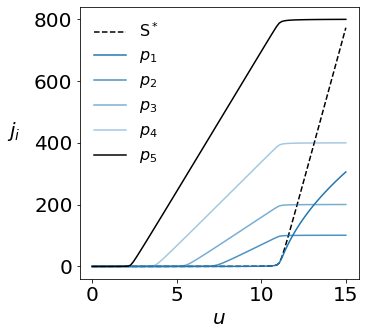

In [114]:
fig,ax = plt.subplots(figsize=(5,5))

ax.plot(fluxes, out_x, label = r'S$^*$',color = 'k',linestyle='--')
ax.plot(fluxes, out_p1, label = r'$p_1$',color='C00000')
ax.plot(fluxes, out_p2, label = r'$p_2$',color='C00000',alpha=0.8)
ax.plot(fluxes, out_p3, label = r'$p_3$',color='C00000',alpha=0.6)
ax.plot(fluxes, out_p4, label = r'$p_4$',color='C00000',alpha=0.4)
ax.plot(fluxes, out_p5, label = r'$p_5$',color='k')
ax.legend(loc='best',frameon=False,fontsize=16)

ax.set_xlabel(r'$u$', fontsize=20)
ax.set_ylabel(r'$j_i$',fontsize=20,labelpad=20,rotation=0)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.axvline(11.5,linestyle='--',color='k',linewidth=0.75)
#fig.text(0.65, 0.07,r'$\Sigma V_m$',fontsize=16)
#ax.set_ylim(0,5)
#ax.set_xlim(0,17)

#plt.savefig('branched_regulated.pdf',bbox_inches='tight')
#plt.savefig('branched_regulated.png',bbox_inches='tight')

In [115]:
#Function corresponding to the split motif, shown in Fig 3A
def split(x,t,k):
    
    dxdt = k[4] - 10*(1-x[1]/x[0]/k[7])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)
    dpdt = 10*(1-x[1]/x[0]/k[7])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1) - k[0]*x[1]/(k[1]+x[1])*k[5]/(k[5]+x[0]) - k[2]*x[1]/(k[3]+x[1])*k[6]/(k[6]+x[0])
    dydt = k[0]*x[1]/(k[1]+x[1])*k[5]/(k[5]+x[0]) - k[0]*x[2]/(k[1]+x[2])
    dzdt = k[2]*x[1]/(k[3]+x[1])*k[6]/(k[6]+x[0]) - k[2]*x[3]/(k[1]+x[3])
    
    return [dxdt,dpdt,dydt,dzdt]

In [116]:
#Similar to above, this function extracts rates from the split system at steady state
def j(x,k):
    j_y = k[0]*x[2]/(k[1]+x[2])
    j_z = k[2]*x[3]/(k[1]+x[3])
    
    return [j_y,j_z]

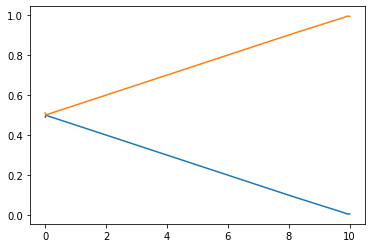

In [117]:
#Split motif with no thermodynamic constraint

x0 = [0.1,0,0,0]
influxes = np.linspace(0,10,800)

n = 100
t = np.linspace(0,100,n)

frac_y = []
frac_z = []

for flux in influxes:
    k = [20,0.1,20,0.1,flux,0.05,10,1000]
    y = odeint(split,x0,t,args=(k,))
    j_y = [j(x,k)[0] for x in y]
    j_z = [j(x,k)[1] for x in y]
    frac_y.append(j_y[-1]/(j_z[-1]+j_y[-1]))
    frac_z.append(j_z[-1]/(j_z[-1]+j_y[-1]))

plt.plot(influxes,frac_y)
plt.plot(influxes,frac_z)

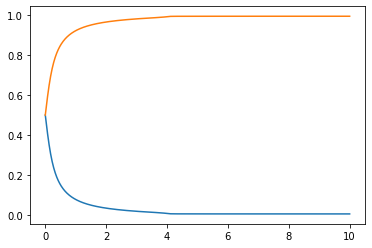

In [119]:
#Split motif with thermodynamic constraint

x0 = [0.1,0,0,0]
influxes_rev = np.linspace(0,10,800)

n = 100
t = np.linspace(0,100,n)

frac_y_rev = []
frac_z_rev = []

for flux in influxes_rev:
    k = [20,0.1,20,0.1,flux,0.05,10,0.01]
    y = odeint(split,x0,t,args=(k,))
    j_y = [j(x,k)[0] for x in y]
    j_z = [j(x,k)[1] for x in y]
    frac_y_rev.append(j_y[-1]/(j_z[-1]+j_y[-1]))
    frac_z_rev.append(j_z[-1]/(j_z[-1]+j_y[-1]))

plt.plot(influxes_rev,frac_y_rev)
plt.plot(influxes_rev,frac_z_rev)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


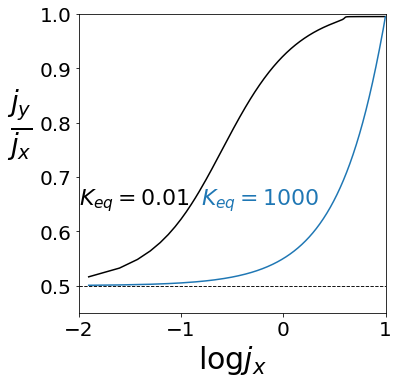

In [120]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

#ax.plot(np.log10(influxes_rev),frac_y_rev,label=r'$\frac{j_y}{j_x}$',linestyle='--',color='k')
ax.plot(np.log10(influxes_rev),frac_z_rev,label=r'$\frac{j_z}{j_x}$',linestyle='-',color='k')
#ax.plot(np.log10(influxes),frac_y,linestyle='--',color='C00000')
ax.plot(np.log10(influxes),frac_z,linestyle='-',color='C00000')

ax.text(-2,0.65,r'$K_{eq} = 0.01$',fontsize=22,color='k')
ax.text(-0.8,0.65,r'$K_{eq} = 1000$',fontsize=22,color='C00000')
ax.set_xlim(-2,1)
ax.set_xlabel(r'$\log j_x $',fontsize=30)
ax.set_ylabel(r'$\frac{j_y}{j_x}$',fontsize=40,rotation=0,labelpad=20)
ax.set_ylim(0.45,1)
ax.axhline(0.5,linestyle='--',color='k',linewidth=0.9)
#ax.text(-1.85,0.2,'Baseline Ratio',fontsize=14)

#ax.legend(frameon=False,fontsize=26,loc='best')
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('branch_K_0.05a.pdf',bbox_inches='tight')
#plt.savefig('branch_K_0.05a.pdf',bbox_inches='tight')

In [121]:
#Function describing the recombine motif shown in Fig 3B
def recombine(x,t,k):
    
    dxdt = k[0] - 10*(1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)
    dpdt = 10*(1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1) - k[2]*x[1]/(k[3]+x[1]) + k[4]*k[5]/(x[0]+k[5])
    
    return [dxdt,dpdt]

In [122]:
#Extracting fluxes from the recombine motif at steady state
def j_recombine(x,k):
    j_y = k[4]*k[5]/(x[0]+k[5]) #PPC
    j_x = 10*(1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1) #MDH
    return [j_x, j_y]

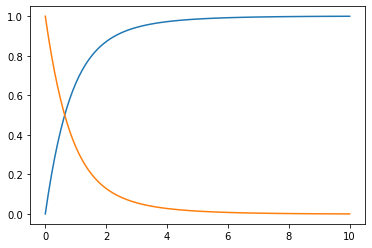

In [123]:
x0 = [0.1,0]
influxes = np.linspace(0,10,100)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y_rev = []
frac_x_rev = []

for flux in influxes:
    k = [flux,0.01,20,0.1,10,0.05]
    y = odeint(recombine,x0,t,args=(k,))
    j_y = [j_recombine(x,k)[0] for x in y]
    j_x = [j_recombine(x,k)[1] for x in y]
    frac_y_rev.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x_rev.append(j_x[-1]/(j_x[-1]+j_y[-1]))

plt.plot(influxes,frac_y_rev)
plt.plot(influxes,frac_x_rev)

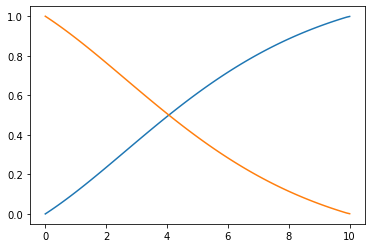

In [124]:
x0 = [0.1,0]
influxes = np.linspace(0,10,100)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y = []
frac_x = []

for flux in influxes:
    k = [flux,1000,20,0.1,10,0.05]
    y = odeint(recombine,x0,t,args=(k,))
    j_y = [j_recombine(x,k)[0] for x in y]
    j_x = [j_recombine(x,k)[1] for x in y]
    frac_y.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x.append(j_x[-1]/(j_x[-1]+j_y[-1]))

plt.plot(influxes,frac_y)
plt.plot(influxes,frac_x)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


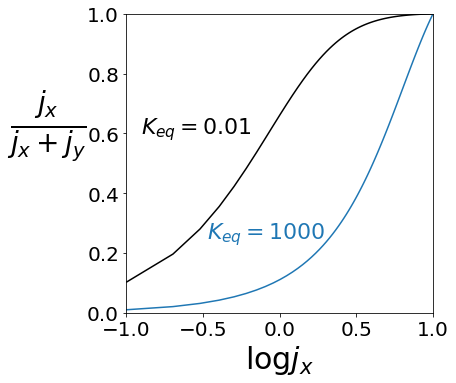

In [125]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

#ax.plot(np.log10(influxes),frac_y_rev,label=r'$\frac{j_y}{j_x+j_y}$',linestyle='--',color='k')
ax.plot(np.log10(influxes),frac_y_rev,label=r'$\frac{j_x}{j_x+j_y}$',linestyle='-',color='k')
#ax.plot(np.log10(influxes),frac_y,linestyle='--',color='C00000')
ax.plot(np.log10(influxes),frac_y,linestyle='-',color='C00000')

#ax.text(-0.3,0.5,r'$K_{eq} = 0.01$',fontsize=14)
#ax.text(0.3,0.5,r'$K_{eq} = 1000$',fontsize=14,color='C00000')
ax.set_xlim(-1,1)
ax.set_xlabel(r'$\log j_x $',fontsize=30)
ax.set_ylabel(r'$\frac{j_x}{j_x+j_y}$',fontsize=40,rotation=0,labelpad=40)
ax.text(-0.9,0.6,r'$K_{eq} = 0.01$',fontsize=22,color='k')
ax.text(-0.47,0.25,r'$K_{eq} = 1000$',fontsize=22,color='C00000')
ax.set_ylim(0,1)

#ax.legend(frameon=False,fontsize=20,loc=(0.005,0.5))
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('recombine_K_0.05a.pdf',bbox_inches='tight')
#plt.savefig('recombine_K_0.05a.pdf',bbox_inches='tight')

In [303]:
#Function examining the effect of directly changing alpha_v on the distribution of fluxes through a split.
#Corresponds to Appendix 2, Fig 1
def branch_dist(V1,V2,K1,K2,u,alpha_v,alpha_k):
    b = V1*K2+V2*K1-u*(K1+K2)
    S = (b-np.sqrt(b**2-4*(u-V2-V1)*(u*K1*K2)))/(2*(u-V1-V2))
    gamma = ((alpha_v*V2*(alpha_v/alpha_k*K1+S))/(V1*(K2+S))+1)**(-1)
    return gamma

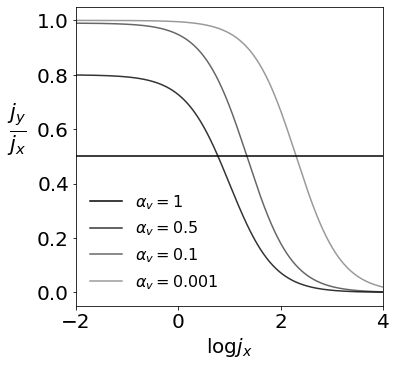

In [304]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(np.log10(vees),gamma,label=r'$\alpha_v = 1$',color='k')
ax.plot(np.log10(vees),gamma_v05,label=r'$\alpha_v = 0.5$',color='k',alpha=0.8)
ax.plot(np.log10(vees),gamma_v01,label=r'$\alpha_v = 0.1$',color='k',alpha=0.6)
ax.plot(np.log10(vees),gamma_v001,label=r'$\alpha_v = 0.001$',color='k',alpha=0.4)

#ax.text(-0.3,0.5,r'$K_{eq} = 0.01$',fontsize=14)
#ax.text(0.3,0.5,r'$K_{eq} = 1000$',fontsize=14,color='C00000')
ax.set_xlim(-1,1)
ax.set_xlabel(r'$\log j_x $',fontsize=20)
ax.set_ylabel(r'$\frac{j_y}{j_x}$',fontsize=30,rotation=0,labelpad=20)
ax.set_xlim(-2,4)

ax.legend(frameon=False,fontsize=16,loc='best')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('split.pdf',bbox_inches='tight')
plt.savefig('split.pdf',bbox_inches='tight')